<a href="https://colab.research.google.com/github/LoniQin/lifelong-ml/blob/main/News_Summarizer_with_HayStack%2C_GEMINI_and_Cohere.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# News Summarizer with HayStack, GEMINI and Cohere

This notebook demonstrates how to build a news summarizer using Haystack, Gemini, and Cohere.
It starts by installing the necessary libraries and setting up API keys.
Then, it shows how to index documents using a simple greeter component.
The main part of the notebook focuses on building a Hacker News summarizer that fetches the top posts, summarizes them using a prompt template and the Gemini LLM, and presents the summaries to the user.
The notebook also includes code for fetching articles from Hacker News, converting them into documents, and embedding them for retrieval.

## Step 1: Environment Setup

- Install necessary libraries: google-ai-haystack, cohere-haystack, and trafilatura are installed using pip for RAG application development.
- Set up API keys: API keys for Gemini and Cohere are retrieved from user data and stored in environment variables.

In [3]:
!pip install -q google-ai-haystack cohere-haystack trafilatura

In [7]:
from haystack import Document, Pipeline, component
from haystack.utils.auth import Secret
from haystack.components.builders import PromptBuilder
from haystack.components.converters import HTMLToDocument
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.writers import DocumentWriter
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack_integrations.components.generators.google_ai import GoogleAIGeminiGenerator
from haystack_integrations.components.embedders.cohere import CohereDocumentEmbedder, CohereTextEmbedder
from haystack.dataclasses import ChatMessage
from typing import List
from google.colab import userdata
import requests
import os
# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")
GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')
CO_API_KEY = userdata.get('CO_API_KEY')
os.environ['CO_API_KEY'] = CO_API_KEY
os.environ["GOOGLE_API_KEY"] = GEMINI_API_KEY

## Step 2: Custom Component Creation

* Define a Greeter component: A custom component named Greeter is created to greet a user by name.
* Build a dialogue builder pipeline: A pipeline is constructed with the Greeter component, a PromptBuilder, and a GoogleAIGeminiGenerator to generate a play script based on a dialogue start.

In [ ]:
@component
class Greeter:

    @component.output_types(greeting=str)
    def run(self, user_name: str):
        return {"greeting": f"Hello {user_name}"}

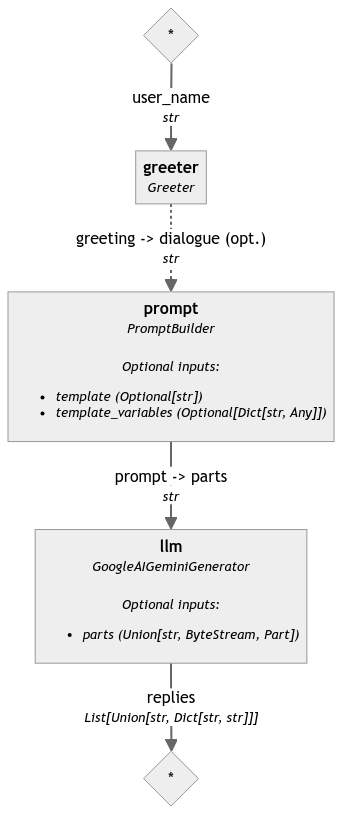

In [14]:
greeter = Greeter()
template = """ You will be given the beginning of a dialogue.
Create a short play script using this as the start of the play.
Start of dialogue: {{ dialogue }}
Full script:
"""
prompt = PromptBuilder(template=template)
llm = GoogleAIGeminiGenerator(model="gemini-1.5-flash")

dialogue_builder = Pipeline()
dialogue_builder.add_component("greeter", greeter)
dialogue_builder.add_component("prompt", prompt)
dialogue_builder.add_component("llm", llm)

dialogue_builder.connect("greeter.greeting", "prompt.dialogue")
dialogue_builder.connect("prompt", "llm")
dialogue_builder.show()

In [15]:
dialogue = dialogue_builder.run({"greeter": {"user_name": "Tuana"}})

print(dialogue["llm"]["replies"][0])

## The Lost Necklace

**Characters:**

* **Tuana:** A young woman, around 20 years old.
* **Elif:** A slightly older woman, Tuana's aunt. 

**Setting:**

The living room of a small, cozy apartment. A worn but comfortable couch sits facing a window overlooking a bustling street. A small table with a tea set sits next to the couch.

**(The scene opens on Tuana sitting on the couch, looking anxious. Elif enters, carrying a tray with two cups of tea.)**

**Elif:** Hello Tuana. You look troubled. What's wrong? 

**Tuana:** (Sighs) Aunt Elif, I've lost it. 

**Elif:** Lost what? Your phone? Your keys? 

**Tuana:** No, it's… it's the necklace. The one Grandma gave me. 

**Elif:** (Her face falls) Oh, Tuana. 

**Tuana:** I know, I know. I'm so stupid. I had it on all day, and then when I was at the cafe, I must have taken it off to put my phone in my bag. I thought I put it back on, but… I can't find it anywhere!

**Elif:** (Puts the tea tray down on the table and sits next to Tuana) It's alri

## Step 3: Hacker News Summarizer Development

* Implement HackernewsNewestFetcher component: A component is created to fetch the newest posts from Hacker News, extract their content, and convert them into Documents.
* Define a prompt template: A prompt template is created to instruct the LLM to summarize the fetched Hacker News posts.
* Build a summarizer pipeline: A pipeline is built with the HackernewsNewestFetcher, PromptBuilder, and GoogleAIGeminiGenerator to fetch, summarize, and present Hacker News posts.

In [17]:
trending_list = requests.get(
        url="https://hacker-news.firebaseio.com/v0/topstories.json?print=pretty"
    )
post = requests.get(
    url=f"https://hacker-news.firebaseio.com/v0/item/{trending_list.json()[0]}.json?print=pretty"
)

print(post.json())

{'by': 'nezaj', 'descendants': 46, 'id': 41322281, 'kids': [41322809, 41323388, 41322813, 41323759, 41323278, 41323712, 41323315, 41322798, 41322841, 41323265, 41323263, 41322782, 41323290, 41323513, 41323623, 41322835, 41322918, 41323117, 41322958, 41322962, 41323138, 41323354, 41322299, 41323302, 41323621, 41323332, 41322694, 41323288], 'score': 152, 'text': 'Hey there HN! We’re Joe and Stopa, and today we’re open sourcing InstantDB, a client-side database that makes it easy to build real-time and collaborative apps like Notion and Figma.<p>Building modern apps these days involves a lot of schleps. For a basic CRUD app you need to spin up servers, wire up endpoints, integrate auth, add permissions, and then marshal data from the backend to the frontend and back again. If you want to deliver a buttery smooth user experience, you’ll need to add optimistic updates and rollbacks. We do these steps over and over for every feature we build, which can make it difficult to build delightful s

In [20]:
@component
class HackernewsNewestFetcher:
    @component.output_types(articles=List[Document])
    def run(self, top_k: int):
        articles = []
        return {"articles": articles}

In [21]:
@component
class HackernewsNewestFetcher:
    def __init__(self):
        fetcher = LinkContentFetcher()
        converter = HTMLToDocument()

        html_conversion_pipeline = Pipeline()
        html_conversion_pipeline.add_component("fetcher", fetcher)
        html_conversion_pipeline.add_component("converter", converter)

        html_conversion_pipeline.connect("fetcher", "converter")
        self.html_pipeline = html_conversion_pipeline

    @component.output_types(articles=List[Document])
    def run(self, top_k: int):
        articles = []
        trending_list = requests.get(
            url="https://hacker-news.firebaseio.com/v0/topstories.json?print=pretty"
        )
        for id in trending_list.json()[0:top_k]:
            post = requests.get(
                url=f"https://hacker-news.firebaseio.com/v0/item/{id}.json?print=pretty"
            )
            if "url" in post.json():
                try:
                    article = self.html_pipeline.run(
                        {"fetcher": {"urls": [post.json()["url"]]}}
                    )
                    articles.append(article["converter"]["documents"][0])
                except:
                    print(f"Can't download {post}, skipped")
            elif "text" in post.json():
                try:
                    articles.append(Document(content=post.json()["text"], meta= {"title": post.json()["title"]}))
                except:
                    print(f"Can't download {post}, skipped")
        return {"articles": articles}

In [22]:
fetcher = HackernewsNewestFetcher()
results = fetcher.run(top_k=3)

print(results['articles'])

[Document(id=ed58eed8ce9c620b4d1b9c6fee4147547172c56e73ed5438440cf8c297508205, content: 'Get Started · Examples · Try the Demo · Docs · Discord
Instant is a client-side database that makes ...', meta: {'content_type': 'text/html', 'url': 'https://github.com/instantdb/instant'}), Document(id=1fb012dce1acf02a8419ea5896d1b83990a57f0ac3929e621bccb3d011aeea18, content: 'Python's Preprocessor
Every now and then you hear outrageous claims such as “Python has no preproces...', meta: {'content_type': 'text/html', 'url': 'https://pydong.org/posts/PythonsPreprocessor/'}), Document(id=dc7e328d1e08727eeda775cd99aaa9a3444fdc6ab30d4852febbc5a8cddba44f, content: 'Notris is a homebrew PSX game, written in C using modern tooling. It's fully playable on original ha...', meta: {'content_type': 'text/html', 'url': 'https://github.com/jbreckmckye/notris'})]


In [23]:
prompt_template = """
You will be provided a few of the top posts in HackerNews.
For each post, provide a brief summary if possible.

Posts:
{% for article in articles %}
  Post:\n
  {{ article.content}}
{% endfor %}
"""

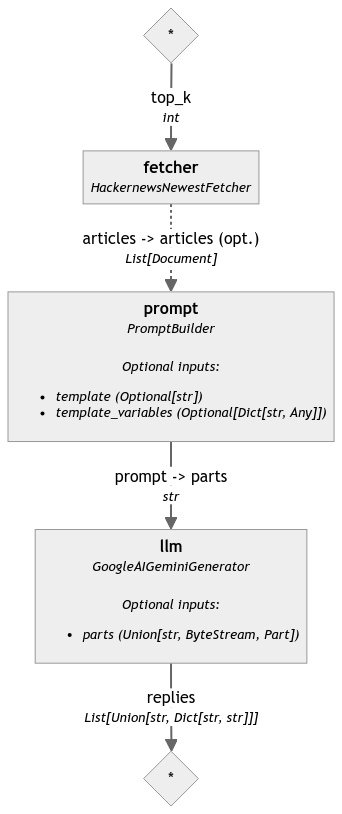

In [25]:
prompt_builder = PromptBuilder(template=prompt_template)
fetcher = HackernewsNewestFetcher()
llm = GoogleAIGeminiGenerator(model="gemini-1.5-flash")

summarizer_pipeline = Pipeline()
summarizer_pipeline.add_component("fetcher", fetcher)
summarizer_pipeline.add_component("prompt", prompt_builder)
summarizer_pipeline.add_component("llm", llm)

summarizer_pipeline.connect("fetcher.articles", "prompt.articles")
summarizer_pipeline.connect("prompt", "llm")
summarizer_pipeline.show()

In [26]:
summaries = summarizer_pipeline.run({"fetcher": {"top_k": 3}})

print(summaries["llm"]["replies"][0])

## Hacker News Post Summaries:

**Post 1: Instant - A Client-Side Database for Real-time & Collaborative Apps**

This post introduces **Instant**, a client-side database designed to simplify building real-time and collaborative applications. Instant handles data fetching, permission checks, offline caching, optimistic updates, and rollbacks, all with built-in multiplayer capabilities. The example code showcases a basic chat app in just 10 lines. The author argues that Instant addresses the complexities of modern app development, particularly with regard to database interactions, by providing a single client-side solution.

**Post 2: Python's Preprocessor - Unleashing the Power of Custom Codecs**

This extensive post explores the capabilities of Python's "preprocessor" by demonstrating how to manipulate source code using custom codecs. The author walks through the process of defining custom codecs, integrating them into Python's initialization process, and using them to implement langua

In [27]:
summaries = summarizer_pipeline.run({"fetcher": {"top_k": 3}})

print(summaries["llm"]["replies"][0])

## Hacker News Post Summaries:

**Post 1: Instant - A Client-Side Database for Building Real-Time Apps**

This post introduces **Instant**, a client-side database that simplifies the development of real-time and collaborative applications. It allows developers to write relational queries and handles data fetching, permission checking, and offline caching automatically. Instant also provides optimistic updates, rollbacks, and multiplayer support by default. The post showcases a simple chat app built with Instant in just 10 lines of code and highlights the benefits of using a client-side database to reduce boilerplate code and complexity.

**Post 2: Python's Preprocessor: Extending the Language in Unexpected Ways**

This article delves into the surprising capabilities of Python's "preprocessor," which allows for extensive language extension through clever use of encoding and path configuration files. The author provides practical examples, including:

* **Custom codecs:** Defining custom

## Step 4: Enhanced Summarization
* Modify prompt template: The prompt template is updated to include the URLs of the Hacker News posts in the summaries.
* Run the summarizer pipeline: The updated pipeline is executed to generate summaries with URLs for the top Hacker News posts.


In [28]:
prompt_template = """
You will be provided a few of the top posts in HackerNews, followed by their URL.
For each post, provide a brief summary followed by the URL the full post can be found at.

Posts:
{% for article in articles %}
  {{ article.content }}
  URL: {{ article.meta["url"] }}
{% endfor %}
"""

prompt_builder = PromptBuilder(template=prompt_template)
fetcher = HackernewsNewestFetcher()
llm = GoogleAIGeminiGenerator(model="gemini-1.5-flash")

summarizer_pipeline = Pipeline()
summarizer_pipeline.add_component("fetcher", fetcher)
summarizer_pipeline.add_component("prompt", prompt_builder)
summarizer_pipeline.add_component("llm", llm)

summarizer_pipeline.connect("fetcher.articles", "prompt.articles")
summarizer_pipeline.connect("prompt", "llm")

🚅 Components
  - fetcher: HackernewsNewestFetcher
  - prompt: PromptBuilder
  - llm: GoogleAIGeminiGenerator
🛤️ Connections
  - fetcher.articles -> prompt.articles (List[Document])
  - prompt.prompt -> llm.parts (str)

In [29]:
summaries = summarizer_pipeline.run({"fetcher": {"top_k": 2}})

print(summaries["llm"]["replies"][0])

## Hacker News Post Summaries:

**1. Instant: Client-side database for real-time apps like Notion and Figma**

Instant is a client-side database designed for building real-time and collaborative applications. It simplifies data management by handling fetching, permissions, and offline caching. With its relational query system and built-in multiplayer capabilities, Instant lets developers focus on user experience rather than complex infrastructure.

**URL:** https://github.com/instantdb/instant

**2. Notris: A homebrew PSX Tetris game written in C**

This post documents the author's journey building a Tetris game for the original PlayStation using C and modern tools. It delves into the technical challenges of PSX development, including graphics rendering, memory management, and random number generation. The author shares his experiences and insights, making this a fascinating read for retro game enthusiasts and programmers alike.

**URL:** https://github.com/jbreckmckye/notris 



## Conclusion

This notebook demonstrated how to leverage the power of Haystack, Gemini, and Cohere to build a simple yet effective news summarizer. By fetching articles from Hacker News, converting them into documents, and using a large language model to generate concise summaries, we were able to quickly extract key information from trending news stories.
The flexibility of Haystack's pipeline architecture allowed us to easily customize the summarization process by incorporating prompt engineering and external APIs. This approach can be further extended to summarize news from various sources, tailor the summaries to specific user preferences, or integrate additional NLP tasks like sentiment analysis or entity recognition.
This example showcases the potential of combining open-source tools and powerful language models to create intelligent applications that can help users stay informed in an increasingly information-saturated world.